# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration / Image Undistortion

For additional info see "./camera_cal/CameraCalibrationImageUndistortionNotebook.ipynb"

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def calibrate(fname, nx=9, ny=6):
    objpoints = []
    imagepoints = []
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imagepoints.append(corners)
        objpoints.append(objp)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)
        return mtx, dist
    else:
        return None

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Applied on an example:

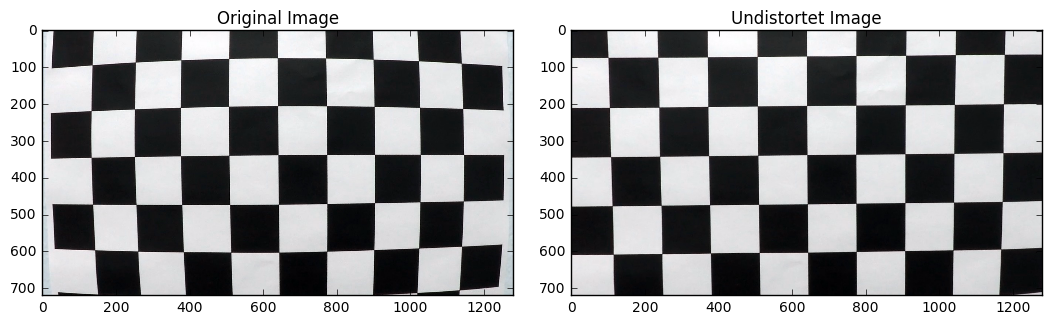

In [3]:
example_image = "./camera_cal/calibration1.jpg"
oimg = cv2.imread(example_image)
mtx, dist = calibrate(example_image, 9, 5)
uimg = undistort(oimg, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(uimg)
ax2.set_title('Undistortet Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholded Binary Image

* The original Image read via mpimg in the RGB colorspace

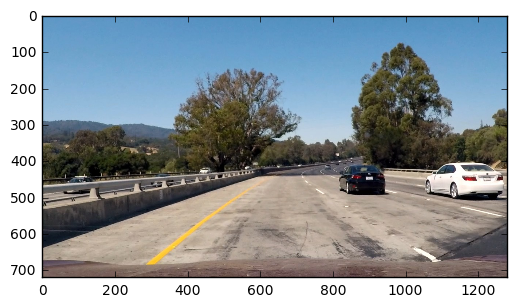

In [118]:
test_image = "./test_images/test1.jpg"
oimg = mpimg.imread(test_image)
plt.imshow(oimg)

* The original image compared to the undistortet image (BGR colorspace)

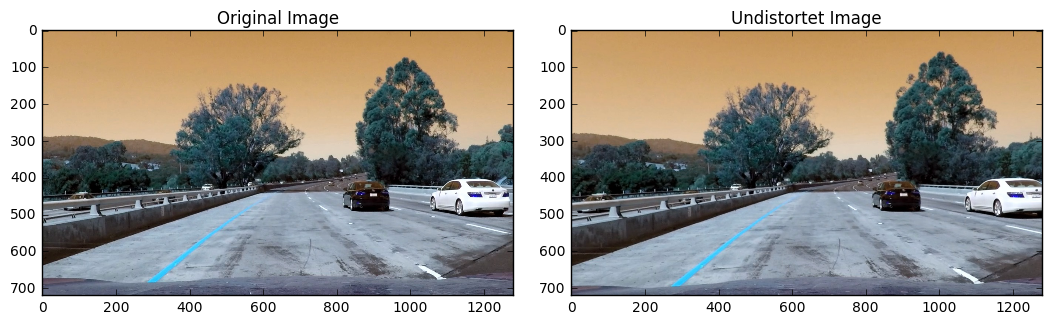

In [119]:
oimg = cv2.imread(test_image)
uimg = undistort(oimg, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(uimg)
ax2.set_title('Undistortet Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Several useful functions to experiment with

In [120]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt( sobelx**2 + sobely**2 )
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

ksize = 3
current_thresh = (20,100)

* Applying Sobel once in x and once in y orientation

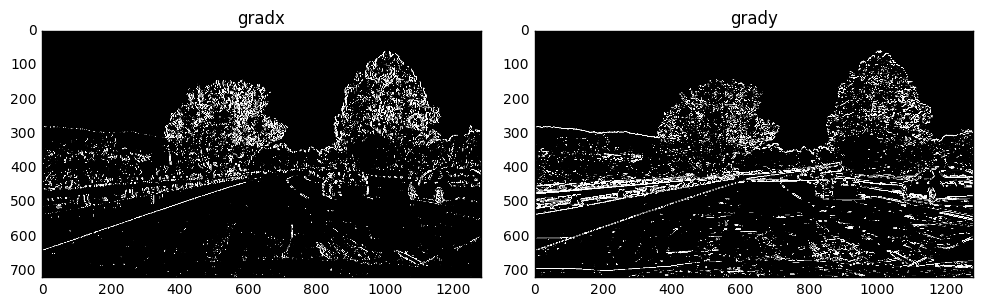

In [121]:
gradx = abs_sobel_thresh(uimg, orient='x', sobel_kernel=ksize, thresh=current_thresh)
grady = abs_sobel_thresh(uimg, orient='y', sobel_kernel=ksize, thresh=current_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(gradx, cmap="gray")
ax1.set_title('gradx', fontsize=12)
ax2.imshow(grady, cmap="gray")
ax2.set_title('grady', fontsize=12)

* Applying a threshold to the overall magnitude of the gradient, in x and y
* Direction of the gradient
* Combining the thresholds

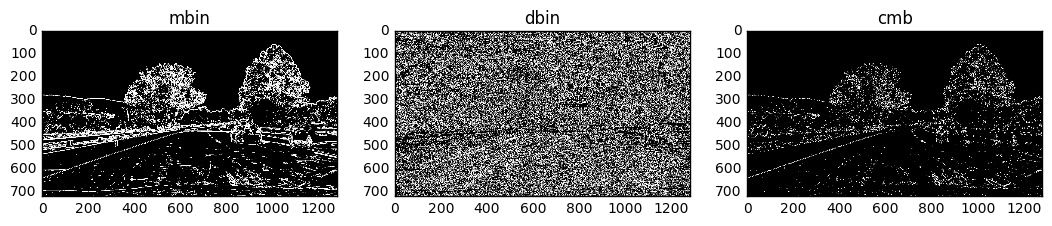

In [122]:
mag_binary = mag_thresh(uimg, sobel_kernel=ksize, thresh=current_thresh)
dir_binary = dir_threshold(uimg, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
f.tight_layout()
ax1.imshow(mag_binary, cmap="gray")
ax1.set_title('mbin', fontsize=12)
ax2.imshow(dir_binary, cmap="gray")
ax2.set_title('dbin', fontsize=12)
ax3.imshow(combined, cmap="gray")
ax3.set_title('cmb', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Combining gradient thresholding with HLS color space

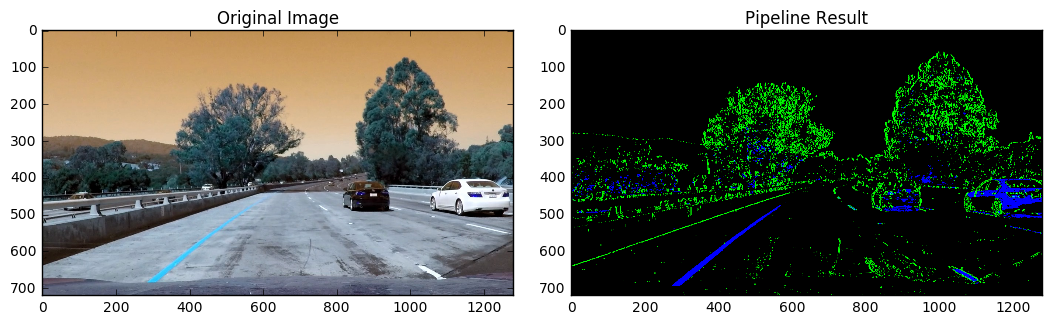

In [123]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(uimg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

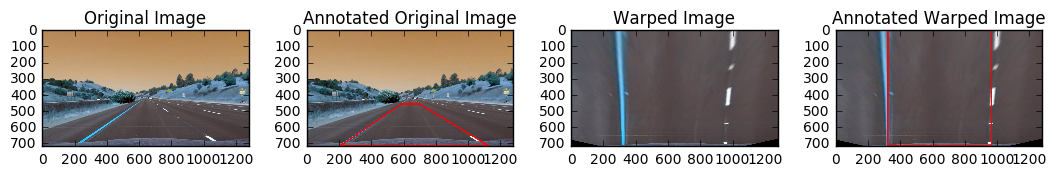

In [124]:
def warper(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
    matrix = cv2.getPerspectiveTransform(src,dst)
    return cv2.warpPerspective(img, matrix, img_size, flags=cv2.INTER_LINEAR)

test_image_straight_lines = "./test_images/straight_lines1.jpg"
uimg = undistort(cv2.imread(test_image_straight_lines), mtx, dist)
wimg = warper(uimg)

tmp_uimg = np.copy(uimg)
tmp_wimg = np.copy(wimg)

img_size = (uimg.shape[1], uimg.shape[0])

src_a = ( int((img_size[0] / 2) - 55), int(img_size[1] / 2 + 100) )
src_b = ( int((img_size[0] / 6) - 10), img_size[1] )
src_c = ( int((img_size[0] * 5 / 6) + 60), img_size[1] )
src_d = ( int(img_size[0] / 2 + 55), int(img_size[1] / 2 + 100) )

dst_a = ( int(img_size[0] / 4), 0 )
dst_b = ( int(img_size[0] / 4), img_size[1] )
dst_c = ( int(img_size[0] * 3 / 4), img_size[1] )
dst_d = ( int(img_size[0] * 3 / 4), 0 )

red = (255,0,0)
linethickness = 8

cv2.line(tmp_uimg, src_a, src_b, red, linethickness)
cv2.line(tmp_uimg, src_c, src_d, red, linethickness)
cv2.line(tmp_uimg, src_a, src_d, red, linethickness)
cv2.line(tmp_uimg, src_b, src_c, red, linethickness)

cv2.line(tmp_wimg, dst_a, dst_b, red, linethickness)
cv2.line(tmp_wimg, dst_c, dst_d, red, linethickness)
cv2.line(tmp_wimg, dst_a, dst_d, red, linethickness)
cv2.line(tmp_wimg, dst_b, dst_c, red, linethickness)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 8))
f.tight_layout()
ax1.imshow(uimg)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(tmp_uimg)
ax2.set_title('Annotated Original Image', fontsize=12)
ax3.imshow(wimg)
ax3.set_title('Warped Image', fontsize=12)
ax4.imshow(tmp_wimg)
ax4.set_title('Annotated Warped Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect Lane-Line Pixels

* Let's prepare a new 'curvy' image to work on

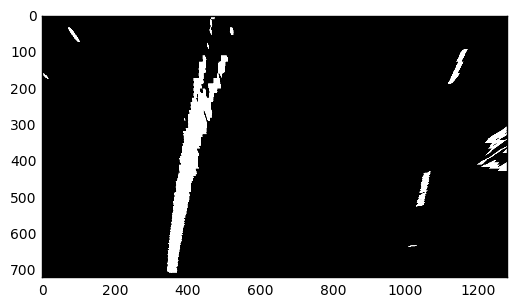

In [125]:
curvy_image = './test_images/test6.jpg'

hls = cv2.cvtColor(cv2.imread(curvy_image), cv2.COLOR_BGR2HLS)
S = hls[:,:,2]
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

# undistortet_curvy_image = undistort(cv2.imread(curvy_image), mtx, dist)
# thresholded_undistorted_curvy_image = abs_sobel_thresh(undistortet_curvy_image, orient='x', sobel_kernel=ksize, thresh=(15,100))
# pipelined_thresholded_undistorted_curvy_image = pipeline(undistortet_curvy_image)
# warped_thresholded_undistorted_curvy_image = warper(pipelined_thresholded_undistorted_curvy_image)
# warped_thresholded_undistortet_curvy_image = warper(thresholded_undistorted_curvy_image)

warper_binary = (warper(binary))

# histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plt.imshow(warper_binary, cmap="gray")
# plt.plot(histogram)

* Let's see the histogram in the lower half of the warped image

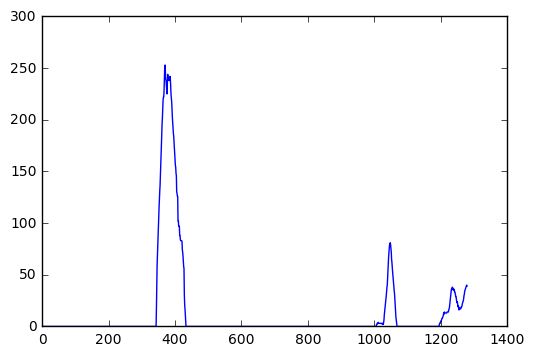

In [126]:
wimg = warper_binary
histogram = np.sum(wimg[wimg.shape[0]//2:,:], axis=0)
plt.plot(histogram)

* Sliding Windows and fit a polynomial

In [127]:
# Create an output image to draw on and visualize the result later
out_img = np.dstack((wimg, wimg, wimg))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(wimg.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = wimg.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = wimg.shape[0] - (window+1)*window_height
    win_y_high = wimg.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# fit a polynomial of degree 2
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# plt.imshow(out_img)

* Let's visualise the result

(720, 0)

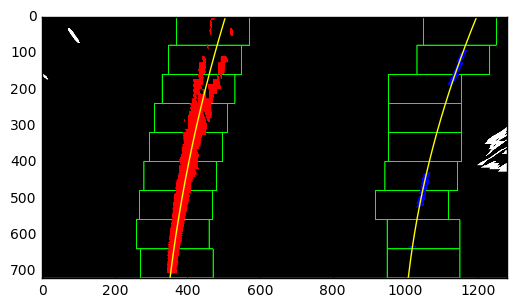

In [128]:
# Generate x and y values for plotting
ploty = np.linspace(0, wimg.shape[0]-1, wimg.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Radius of curvature

In [129]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

# position of car
def position_of_car(leftx, rightx, width):
    lane_width_in_pixels = rightx - leftx
    lane_center = (lane_width_in_pixels / 2) + leftx
    image_center = width / 2
    pixel_to_meter = lane_width_in_pixels / 3.7
    offset = (abs(lane_center - image_center))
    return (offset / pixel_to_meter)

print(position_of_car(leftx[0], rightx[0], wimg.shape[1]))

1313.07263757 m 804.149389074 m
0.253387334315


## Draw back on original image

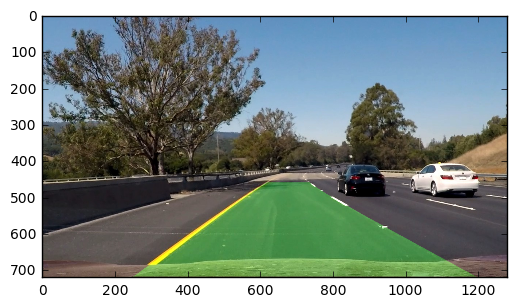

In [130]:
def draw_back(img, original_img, left_fitx, right_fitx, ploty):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
    minv = cv2.getPerspectiveTransform(dst,src)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(wimg).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    
    return result

final_image = cv2.cvtColor(draw_back(wimg, cv2.imread(curvy_image), left_fitx, right_fitx, ploty), cv2.COLOR_BGR2RGB)
plt.imshow(final_image)

## Video

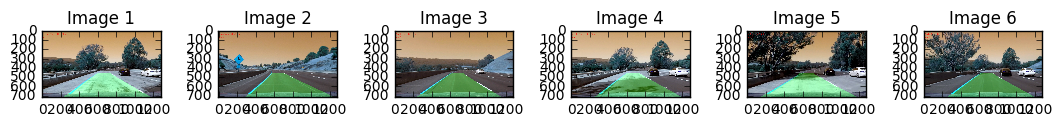

In [131]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

cache = deque(maxlen=1000)

def preprocess_image(image, thresh = (90,255)):
    # S for more stability
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return warper(binary)


def calc_peaks(histogram):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return (leftx_base, rightx_base)


def calc_linepixelpositions(image, nwindows, leftx, rightx, margin=100, minpix=50):
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx - margin
        win_xleft_high = leftx + margin
        win_xright_low = rightx - margin
        win_xright_high = rightx + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty, rightx, righty)


def fit_polynomial(leftx, lefty, rightx, righty, ploty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (left_fitx, right_fitx)


def calc_radii(leftx, lefty, rightx, righty, ploty):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)


def insane(left_curverad, right_curverad, leftx, lefty, rightx, righty, image):
    return (
                left_curverad < 290 or 
                right_curverad < 290 or
                leftx.size == 0 or
                lefty.size == 0 or
                rightx.size == 0 or
                righty.size == 0 or 
                position_of_car(leftx[0], rightx[0], image.shape[1]) > 0.35
    )


def annotate_image(image, left_curverad, right_curverad, car_position):
    left = str("{0:.2f}m ".format(left_curverad))
    right = str("{0:.2f}m ".format(right_curverad))
    t = left + right
    cv2.putText(image, t, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 1, cv2.LINE_AA)   
    t = str("{0:.2f}".format(car_position))
    cv2.putText(image, t, (10,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 1, cv2.LINE_AA)


def process_image(original_image, nwindows = 9):
    # cache.clear()
    image = preprocess_image(original_image)
    # Prepare Histogram 
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    leftx_base, rightx_base = calc_peaks(histogram)
    leftx, lefty, rightx, righty = calc_linepixelpositions(image, nwindows, leftx_base, rightx_base)
    if(leftx.size != 0 and lefty.size != 0 and rightx.size != 0 and righty.size != 0):
        cache.append((leftx,lefty,rightx,righty))
    else:
        if(len(cache)==0):
            return original_image
        else:
            leftx, lefty, rightx, righty = cache.pop()
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    # Generate x and y values for plotting
    left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, ploty)
    left_curverad, right_curverad = calc_radii(leftx, lefty, rightx, righty, ploty)
    # Sanity Check
    while(insane(left_curverad, right_curverad, leftx, lefty, rightx, righty, image) and (len(cache)!=0)):
        leftx, lefty, rightx, righty = cache.pop()
        left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, ploty)
        left_curverad, right_curverad = calc_radii(leftx, lefty, rightx, righty, ploty)
        
    annotate_image(original_image, left_curverad, right_curverad, position_of_car(leftx[0], rightx[0], image.shape[1]))    
    return draw_back(image, original_image, left_fitx, right_fitx, ploty)


cache.clear()
timg1 = process_image(cv2.imread("./test_images/test1.jpg"))
timg2 = process_image(cv2.imread("./test_images/test2.jpg"))
timg3 = process_image(cv2.imread("./test_images/test3.jpg"))
timg4 = process_image(cv2.imread("./test_images/test4.jpg"))
timg5 = process_image(cv2.imread("./test_images/test5.jpg"))
timg6 = process_image(cv2.imread("./test_images/test6.jpg"))
# plt.imshow(timg5)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(10, 8))
f.tight_layout()
ax1.imshow(timg1)
ax1.set_title('Image 1', fontsize=12)
ax2.imshow(timg2)
ax2.set_title('Image 2', fontsize=12)
ax3.imshow(timg3)
ax3.set_title('Image 3', fontsize=12)
ax4.imshow(timg4)
ax4.set_title('Image 4', fontsize=12)
ax5.imshow(timg5)
ax5.set_title('Image 5', fontsize=12)
ax6.imshow(timg6)
ax6.set_title('Image 6', fontsize=12)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [117]:
cache.clear()
output = "project_output_video.mp4"
clip = VideoFileClip("./project_video.mp4")
new_clip = clip.fl_image(process_image)
new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4


[MoviePy] Writing video project_output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<01:10, 17.92it/s]

  0%|          | 5/1261 [00:00<01:05, 19.12it/s]

  1%|          | 8/1261 [00:00<01:04, 19.44it/s]

  1%|          | 10/1261 [00:00<01:07, 18.61it/s]

  1%|          | 13/1261 [00:00<01:04, 19.24it/s]

  1%|          | 15/1261 [00:00<01:04, 19.33it/s]

  1%|▏         | 18/1261 [00:00<01:03, 19.72it/s]

  2%|▏         | 20/1261 [00:01<01:07, 18.44it/s]

  2%|▏         | 22/1261 [00:01<01:10, 17.56it/s]

  2%|▏         | 24/1261 [00:01<01:10, 17.51it/s]

  2%|▏         | 26/1261 [00:01<01:09, 17.84it/s]

  2%|▏         | 28/1261 [00:01<01:07, 18.20it/s]

  2%|▏         | 30/1261 [00:01<01:10, 17.55it/s]

  3%|▎         | 32/1261 [00:01<01:08, 17.88it/s]

  3%|▎         | 34/1261 [00:01<01:06, 18.46it/s]

  3%|▎         | 36/1261 [00:01<01:07, 18.14it/s]

  3%|▎         | 38/1261 [00:02<01:09, 17.55it/s]

  3%|▎         | 40/1261 [00:02<01:10, 17.36it/s]

  3%|▎         | 43/1261 [00:02<01:08, 17.83it/s]

  4%|▎         | 45/1261 [00:02<01:11, 17.07it/s]

  4%|▎         | 47/1261 [00:02<01:21, 14.95it/s]

  4%|▍         | 49/1261 [00:02<01:26, 14.01it/s]

  4%|▍         | 51/1261 [00:02<01:24, 14.32it/s]

  4%|▍         | 53/1261 [00:03<01:28, 13.71it/s]

  4%|▍         | 55/1261 [00:03<01:26, 14.00it/s]

  5%|▍         | 57/1261 [00:03<01:43, 11.60it/s]

  5%|▍         | 59/1261 [00:03<01:51, 10.80it/s]

  5%|▍         | 61/1261 [00:03<01:54, 10.47it/s]

  5%|▍         | 63/1261 [00:04<01:50, 10.86it/s]

  5%|▌         | 65/1261 [00:04<01:46, 11.20it/s]

  5%|▌         | 67/1261 [00:04<01:39, 12.04it/s]

  5%|▌         | 69/1261 [00:04<01:36, 12.36it/s]

  6%|▌         | 71/1261 [00:04<01:30, 13.08it/s]

  6%|▌         | 73/1261 [00:04<01:30, 13.07it/s]

  6%|▌         | 75/1261 [00:05<01:48, 10.98it/s]

  6%|▌         | 77/1261 [00:05<01:42, 11.53it/s]

  6%|▋         | 79/1261 [00:05<01:38, 12.03it/s]

  6%|▋         | 81/1261 [00:05<01:34, 12.45it/s]

  7%|▋         | 83/1261 [00:05<01:33, 12.63it/s]

  7%|▋         | 85/1261 [00:05<01:28, 13.31it/s]

  7%|▋         | 87/1261 [00:05<01:25, 13.67it/s]

  7%|▋         | 89/1261 [00:06<01:22, 14.17it/s]

  7%|▋         | 91/1261 [00:06<01:29, 13.05it/s]

  7%|▋         | 93/1261 [00:06<01:26, 13.43it/s]

  8%|▊         | 95/1261 [00:06<01:28, 13.20it/s]

  8%|▊         | 97/1261 [00:06<01:50, 10.55it/s]

  8%|▊         | 99/1261 [00:07<02:00,  9.67it/s]

  8%|▊         | 101/1261 [00:07<02:02,  9.49it/s]

  8%|▊         | 103/1261 [00:07<01:57,  9.90it/s]

  8%|▊         | 105/1261 [00:07<01:50, 10.43it/s]

  8%|▊         | 107/1261 [00:07<01:43, 11.16it/s]

  9%|▊         | 109/1261 [00:07<01:41, 11.38it/s]

  9%|▉         | 111/1261 [00:08<01:41, 11.34it/s]

  9%|▉         | 113/1261 [00:08<01:38, 11.65it/s]

  9%|▉         | 115/1261 [00:08<01:38, 11.67it/s]

  9%|▉         | 117/1261 [00:08<01:37, 11.68it/s]

  9%|▉         | 119/1261 [00:08<01:37, 11.75it/s]

 10%|▉         | 121/1261 [00:08<01:33, 12.22it/s]

 10%|▉         | 123/1261 [00:09<01:30, 12.53it/s]

 10%|▉         | 125/1261 [00:09<01:44, 10.82it/s]

 10%|█         | 127/1261 [00:09<01:42, 11.11it/s]

 10%|█         | 129/1261 [00:09<01:35, 11.80it/s]

 10%|█         | 131/1261 [00:09<01:34, 11.94it/s]

 11%|█         | 133/1261 [00:09<01:31, 12.33it/s]

 11%|█         | 135/1261 [00:10<01:30, 12.49it/s]

 11%|█         | 137/1261 [00:10<01:28, 12.75it/s]

 11%|█         | 139/1261 [00:10<01:26, 13.02it/s]

 11%|█         | 141/1261 [00:10<01:24, 13.30it/s]

 11%|█▏        | 143/1261 [00:10<01:24, 13.22it/s]

 11%|█▏        | 145/1261 [00:10<01:22, 13.57it/s]

 12%|█▏        | 147/1261 [00:10<01:23, 13.31it/s]

 12%|█▏        | 149/1261 [00:11<01:20, 13.73it/s]

 12%|█▏        | 151/1261 [00:11<01:18, 14.10it/s]

 12%|█▏        | 153/1261 [00:11<01:17, 14.26it/s]

 12%|█▏        | 155/1261 [00:11<01:19, 13.94it/s]

 12%|█▏        | 157/1261 [00:11<01:16, 14.41it/s]

 13%|█▎        | 159/1261 [00:11<01:12, 15.17it/s]

 13%|█▎        | 161/1261 [00:11<01:11, 15.30it/s]

 13%|█▎        | 163/1261 [00:12<01:12, 15.08it/s]

 13%|█▎        | 165/1261 [00:12<01:16, 14.31it/s]

 13%|█▎        | 167/1261 [00:12<01:15, 14.47it/s]

 13%|█▎        | 169/1261 [00:12<01:15, 14.46it/s]

 14%|█▎        | 171/1261 [00:12<01:15, 14.39it/s]

 14%|█▎        | 173/1261 [00:12<01:15, 14.39it/s]

 14%|█▍        | 175/1261 [00:12<01:14, 14.60it/s]

 14%|█▍        | 177/1261 [00:13<01:12, 14.86it/s]

 14%|█▍        | 179/1261 [00:13<01:11, 15.12it/s]

 14%|█▍        | 181/1261 [00:13<01:09, 15.44it/s]

 15%|█▍        | 183/1261 [00:13<01:09, 15.56it/s]

 15%|█▍        | 185/1261 [00:13<01:10, 15.30it/s]

 15%|█▍        | 187/1261 [00:13<01:15, 14.32it/s]

 15%|█▍        | 189/1261 [00:13<01:23, 12.81it/s]

 15%|█▌        | 191/1261 [00:14<01:21, 13.13it/s]

 15%|█▌        | 193/1261 [00:14<01:20, 13.35it/s]

 15%|█▌        | 195/1261 [00:14<01:17, 13.84it/s]

 16%|█▌        | 197/1261 [00:14<01:15, 14.01it/s]

 16%|█▌        | 199/1261 [00:14<01:15, 14.11it/s]

 16%|█▌        | 201/1261 [00:14<01:15, 14.12it/s]

 16%|█▌        | 203/1261 [00:14<01:13, 14.42it/s]

 16%|█▋        | 205/1261 [00:14<01:11, 14.69it/s]

 16%|█▋        | 207/1261 [00:15<01:10, 14.96it/s]

 17%|█▋        | 209/1261 [00:15<01:09, 15.05it/s]

 17%|█▋        | 211/1261 [00:15<01:08, 15.36it/s]

 17%|█▋        | 213/1261 [00:15<01:07, 15.43it/s]

 17%|█▋        | 215/1261 [00:15<01:07, 15.51it/s]

 17%|█▋        | 217/1261 [00:15<01:06, 15.59it/s]

 17%|█▋        | 219/1261 [00:15<01:06, 15.67it/s]

 18%|█▊        | 221/1261 [00:16<01:09, 15.00it/s]

 18%|█▊        | 223/1261 [00:16<01:08, 15.26it/s]

 18%|█▊        | 225/1261 [00:16<01:07, 15.44it/s]

 18%|█▊        | 227/1261 [00:16<01:07, 15.34it/s]

 18%|█▊        | 229/1261 [00:16<01:06, 15.42it/s]

 18%|█▊        | 231/1261 [00:16<01:06, 15.50it/s]

 18%|█▊        | 233/1261 [00:16<01:08, 15.07it/s]

 19%|█▊        | 235/1261 [00:16<01:09, 14.77it/s]

 19%|█▉        | 237/1261 [00:17<01:10, 14.50it/s]

 19%|█▉        | 239/1261 [00:17<01:13, 13.93it/s]

 19%|█▉        | 241/1261 [00:17<01:11, 14.18it/s]

 19%|█▉        | 243/1261 [00:17<01:11, 14.27it/s]

 19%|█▉        | 245/1261 [00:17<01:09, 14.57it/s]

 20%|█▉        | 247/1261 [00:17<01:08, 14.90it/s]

 20%|█▉        | 249/1261 [00:17<01:07, 14.92it/s]

 20%|█▉        | 251/1261 [00:18<01:07, 14.87it/s]

 20%|██        | 253/1261 [00:18<01:10, 14.30it/s]

 20%|██        | 255/1261 [00:18<01:10, 14.20it/s]

 20%|██        | 257/1261 [00:18<01:10, 14.24it/s]

 21%|██        | 259/1261 [00:18<01:09, 14.45it/s]

 21%|██        | 261/1261 [00:18<01:08, 14.64it/s]

 21%|██        | 263/1261 [00:18<01:08, 14.65it/s]

 21%|██        | 265/1261 [00:19<01:07, 14.76it/s]

 21%|██        | 267/1261 [00:19<01:11, 13.87it/s]

 21%|██▏       | 269/1261 [00:19<01:10, 13.99it/s]

 21%|██▏       | 271/1261 [00:19<01:10, 14.09it/s]

 22%|██▏       | 273/1261 [00:19<01:09, 14.27it/s]

 22%|██▏       | 275/1261 [00:19<01:07, 14.60it/s]

 22%|██▏       | 277/1261 [00:19<01:06, 14.81it/s]

 22%|██▏       | 279/1261 [00:19<01:04, 15.21it/s]

 22%|██▏       | 281/1261 [00:20<01:03, 15.44it/s]

 22%|██▏       | 283/1261 [00:20<01:03, 15.51it/s]

 23%|██▎       | 285/1261 [00:20<01:03, 15.32it/s]

 23%|██▎       | 287/1261 [00:20<01:05, 14.87it/s]

 23%|██▎       | 289/1261 [00:20<01:04, 15.08it/s]

 23%|██▎       | 291/1261 [00:20<01:04, 15.04it/s]

 23%|██▎       | 293/1261 [00:20<01:05, 14.86it/s]

 23%|██▎       | 295/1261 [00:21<01:05, 14.81it/s]

 24%|██▎       | 297/1261 [00:21<01:04, 14.89it/s]

 24%|██▎       | 299/1261 [00:21<01:03, 15.14it/s]

 24%|██▍       | 301/1261 [00:21<01:02, 15.26it/s]

 24%|██▍       | 303/1261 [00:21<01:03, 15.13it/s]

 24%|██▍       | 305/1261 [00:21<01:02, 15.32it/s]

 24%|██▍       | 307/1261 [00:21<01:01, 15.39it/s]

 25%|██▍       | 309/1261 [00:21<01:01, 15.41it/s]

 25%|██▍       | 311/1261 [00:22<01:00, 15.59it/s]

 25%|██▍       | 313/1261 [00:22<01:00, 15.75it/s]

 25%|██▍       | 315/1261 [00:22<00:59, 15.77it/s]

 25%|██▌       | 317/1261 [00:22<00:59, 15.81it/s]

 25%|██▌       | 319/1261 [00:22<00:59, 15.89it/s]

 25%|██▌       | 321/1261 [00:22<01:04, 14.64it/s]

 26%|██▌       | 323/1261 [00:22<01:03, 14.67it/s]

 26%|██▌       | 325/1261 [00:23<01:06, 14.03it/s]

 26%|██▌       | 327/1261 [00:23<01:07, 13.74it/s]

 26%|██▌       | 329/1261 [00:23<01:08, 13.66it/s]

 26%|██▌       | 331/1261 [00:23<01:06, 13.99it/s]

 26%|██▋       | 333/1261 [00:23<01:07, 13.79it/s]

 27%|██▋       | 335/1261 [00:23<01:08, 13.56it/s]

 27%|██▋       | 337/1261 [00:23<01:08, 13.44it/s]

 27%|██▋       | 339/1261 [00:24<01:08, 13.47it/s]

 27%|██▋       | 341/1261 [00:24<01:09, 13.30it/s]

 27%|██▋       | 343/1261 [00:24<01:07, 13.54it/s]

 27%|██▋       | 345/1261 [00:24<01:08, 13.33it/s]

 28%|██▊       | 347/1261 [00:24<01:11, 12.73it/s]

 28%|██▊       | 349/1261 [00:24<01:16, 11.89it/s]

 28%|██▊       | 351/1261 [00:25<01:17, 11.80it/s]

 28%|██▊       | 353/1261 [00:25<01:13, 12.42it/s]

 28%|██▊       | 355/1261 [00:25<01:09, 13.02it/s]

 28%|██▊       | 357/1261 [00:25<01:07, 13.39it/s]

 28%|██▊       | 359/1261 [00:25<01:08, 13.10it/s]

 29%|██▊       | 361/1261 [00:25<01:06, 13.55it/s]

 29%|██▉       | 363/1261 [00:25<01:04, 13.84it/s]

 29%|██▉       | 365/1261 [00:26<01:03, 14.11it/s]

 29%|██▉       | 367/1261 [00:26<01:02, 14.37it/s]

 29%|██▉       | 369/1261 [00:26<01:00, 14.65it/s]

 29%|██▉       | 371/1261 [00:26<01:02, 14.28it/s]

 30%|██▉       | 373/1261 [00:26<01:02, 14.16it/s]

 30%|██▉       | 375/1261 [00:26<01:02, 14.09it/s]

 30%|██▉       | 377/1261 [00:26<01:03, 13.88it/s]

 30%|███       | 379/1261 [00:27<01:03, 13.85it/s]

 30%|███       | 381/1261 [00:27<01:05, 13.34it/s]

 30%|███       | 383/1261 [00:27<01:03, 13.83it/s]

 31%|███       | 385/1261 [00:27<01:01, 14.21it/s]

 31%|███       | 387/1261 [00:27<00:59, 14.71it/s]

 31%|███       | 389/1261 [00:27<00:59, 14.74it/s]

 31%|███       | 391/1261 [00:27<00:58, 14.80it/s]

 31%|███       | 393/1261 [00:28<00:58, 14.72it/s]

 31%|███▏      | 395/1261 [00:28<00:59, 14.50it/s]

 31%|███▏      | 397/1261 [00:28<00:58, 14.68it/s]

 32%|███▏      | 399/1261 [00:28<00:57, 15.04it/s]

 32%|███▏      | 401/1261 [00:28<00:56, 15.17it/s]

 32%|███▏      | 403/1261 [00:28<00:56, 15.29it/s]

 32%|███▏      | 405/1261 [00:28<00:55, 15.45it/s]

 32%|███▏      | 407/1261 [00:28<00:55, 15.38it/s]

 32%|███▏      | 409/1261 [00:29<00:59, 14.38it/s]

 33%|███▎      | 411/1261 [00:29<01:04, 13.15it/s]

 33%|███▎      | 413/1261 [00:29<01:03, 13.26it/s]

 33%|███▎      | 415/1261 [00:29<01:01, 13.73it/s]

 33%|███▎      | 417/1261 [00:29<00:59, 14.13it/s]

 33%|███▎      | 419/1261 [00:29<00:58, 14.35it/s]

 33%|███▎      | 421/1261 [00:29<00:58, 14.45it/s]

 34%|███▎      | 423/1261 [00:30<00:57, 14.56it/s]

 34%|███▎      | 425/1261 [00:30<00:57, 14.42it/s]

 34%|███▍      | 427/1261 [00:30<00:58, 14.32it/s]

 34%|███▍      | 429/1261 [00:30<01:00, 13.77it/s]

 34%|███▍      | 431/1261 [00:30<01:00, 13.73it/s]

 34%|███▍      | 433/1261 [00:30<01:00, 13.78it/s]

 34%|███▍      | 435/1261 [00:30<01:00, 13.59it/s]

 35%|███▍      | 437/1261 [00:31<01:02, 13.25it/s]

 35%|███▍      | 439/1261 [00:31<01:01, 13.33it/s]

 35%|███▍      | 441/1261 [00:31<01:00, 13.48it/s]

 35%|███▌      | 443/1261 [00:31<01:04, 12.66it/s]

 35%|███▌      | 445/1261 [00:31<01:06, 12.19it/s]

 35%|███▌      | 447/1261 [00:31<01:06, 12.31it/s]

 36%|███▌      | 449/1261 [00:32<01:04, 12.58it/s]

 36%|███▌      | 451/1261 [00:32<01:03, 12.76it/s]

 36%|███▌      | 453/1261 [00:32<01:02, 12.92it/s]

 36%|███▌      | 455/1261 [00:32<01:01, 13.06it/s]

 36%|███▌      | 457/1261 [00:32<01:01, 13.10it/s]

 36%|███▋      | 459/1261 [00:32<01:00, 13.23it/s]

 37%|███▋      | 461/1261 [00:32<01:00, 13.13it/s]

 37%|███▋      | 463/1261 [00:33<01:00, 13.24it/s]

 37%|███▋      | 465/1261 [00:33<00:59, 13.32it/s]

 37%|███▋      | 467/1261 [00:33<01:00, 13.15it/s]

 37%|███▋      | 469/1261 [00:33<00:59, 13.27it/s]

 37%|███▋      | 471/1261 [00:33<01:06, 11.85it/s]

 38%|███▊      | 473/1261 [00:33<01:05, 11.95it/s]

 38%|███▊      | 475/1261 [00:34<01:04, 12.21it/s]

 38%|███▊      | 477/1261 [00:34<01:00, 12.95it/s]

 38%|███▊      | 479/1261 [00:34<00:57, 13.65it/s]

 38%|███▊      | 481/1261 [00:34<00:55, 13.99it/s]

 38%|███▊      | 483/1261 [00:34<00:58, 13.39it/s]

 38%|███▊      | 485/1261 [00:34<00:57, 13.55it/s]

 39%|███▊      | 487/1261 [00:34<00:56, 13.59it/s]

 39%|███▉      | 489/1261 [00:35<00:56, 13.59it/s]

 39%|███▉      | 491/1261 [00:35<00:55, 13.93it/s]

 39%|███▉      | 493/1261 [00:35<00:53, 14.29it/s]

 39%|███▉      | 495/1261 [00:35<00:52, 14.57it/s]

 39%|███▉      | 497/1261 [00:35<00:53, 14.30it/s]

 40%|███▉      | 499/1261 [00:35<00:55, 13.83it/s]

 40%|███▉      | 501/1261 [00:35<00:55, 13.70it/s]

 40%|███▉      | 503/1261 [00:36<00:57, 13.08it/s]

 40%|████      | 505/1261 [00:36<00:55, 13.56it/s]

 40%|████      | 507/1261 [00:36<00:55, 13.62it/s]

 40%|████      | 509/1261 [00:36<00:55, 13.51it/s]

 41%|████      | 511/1261 [00:36<00:56, 13.17it/s]

 41%|████      | 513/1261 [00:36<00:55, 13.52it/s]

 41%|████      | 515/1261 [00:37<00:53, 13.91it/s]

 41%|████      | 517/1261 [00:37<00:53, 13.89it/s]

 41%|████      | 519/1261 [00:37<00:52, 14.27it/s]

 41%|████▏     | 521/1261 [00:37<00:50, 14.52it/s]

 41%|████▏     | 523/1261 [00:37<00:52, 14.17it/s]

 42%|████▏     | 525/1261 [00:37<00:53, 13.75it/s]

 42%|████▏     | 527/1261 [00:37<00:53, 13.63it/s]

 42%|████▏     | 529/1261 [00:38<00:53, 13.70it/s]

 42%|████▏     | 531/1261 [00:38<00:53, 13.65it/s]

 42%|████▏     | 533/1261 [00:38<00:56, 12.96it/s]

 42%|████▏     | 535/1261 [00:38<00:55, 13.07it/s]

 43%|████▎     | 537/1261 [00:38<00:55, 13.04it/s]

 43%|████▎     | 539/1261 [00:38<00:53, 13.41it/s]

 43%|████▎     | 541/1261 [00:38<00:54, 13.10it/s]

 43%|████▎     | 543/1261 [00:39<00:55, 12.84it/s]

 43%|████▎     | 545/1261 [00:39<00:54, 13.10it/s]

 43%|████▎     | 547/1261 [00:39<00:53, 13.31it/s]

 44%|████▎     | 549/1261 [00:39<00:53, 13.25it/s]

 44%|████▎     | 551/1261 [00:39<00:52, 13.49it/s]

 44%|████▍     | 553/1261 [00:39<00:54, 12.90it/s]

 44%|████▍     | 555/1261 [00:40<00:53, 13.07it/s]

 44%|████▍     | 557/1261 [00:40<00:52, 13.42it/s]

 44%|████▍     | 559/1261 [00:40<00:52, 13.43it/s]

 44%|████▍     | 561/1261 [00:40<00:53, 13.06it/s]

 45%|████▍     | 563/1261 [00:40<00:53, 13.01it/s]

 45%|████▍     | 565/1261 [00:40<00:51, 13.63it/s]

 45%|████▍     | 567/1261 [00:40<00:49, 14.13it/s]

 45%|████▌     | 569/1261 [00:40<00:47, 14.58it/s]

 45%|████▌     | 571/1261 [00:41<00:46, 14.69it/s]

 45%|████▌     | 573/1261 [00:41<00:45, 15.08it/s]

 46%|████▌     | 575/1261 [00:41<00:45, 15.16it/s]

 46%|████▌     | 577/1261 [00:41<00:44, 15.49it/s]

 46%|████▌     | 579/1261 [00:41<00:43, 15.53it/s]

 46%|████▌     | 581/1261 [00:41<00:43, 15.48it/s]

 46%|████▌     | 583/1261 [00:41<00:44, 15.39it/s]

 46%|████▋     | 585/1261 [00:42<00:43, 15.42it/s]

 47%|████▋     | 587/1261 [00:42<00:43, 15.32it/s]

 47%|████▋     | 589/1261 [00:42<00:45, 14.86it/s]

 47%|████▋     | 591/1261 [00:42<00:46, 14.48it/s]

 47%|████▋     | 593/1261 [00:42<00:44, 14.86it/s]

 47%|████▋     | 595/1261 [00:42<00:46, 14.42it/s]

 47%|████▋     | 597/1261 [00:42<00:46, 14.32it/s]

 48%|████▊     | 599/1261 [00:42<00:45, 14.57it/s]

 48%|████▊     | 601/1261 [00:43<00:48, 13.63it/s]

 48%|████▊     | 603/1261 [00:43<00:47, 13.91it/s]

 48%|████▊     | 605/1261 [00:43<00:49, 13.24it/s]

 48%|████▊     | 607/1261 [00:43<00:49, 13.20it/s]

 48%|████▊     | 609/1261 [00:43<00:47, 13.65it/s]

 48%|████▊     | 611/1261 [00:43<00:50, 12.78it/s]

 49%|████▊     | 613/1261 [00:44<00:51, 12.48it/s]

 49%|████▉     | 615/1261 [00:44<00:50, 12.76it/s]

 49%|████▉     | 617/1261 [00:44<00:48, 13.31it/s]

 49%|████▉     | 619/1261 [00:44<00:49, 13.10it/s]

 49%|████▉     | 621/1261 [00:44<00:48, 13.32it/s]

 49%|████▉     | 623/1261 [00:44<00:48, 13.13it/s]

 50%|████▉     | 625/1261 [00:45<00:48, 13.05it/s]

 50%|████▉     | 627/1261 [00:45<00:49, 12.92it/s]

 50%|████▉     | 629/1261 [00:45<00:46, 13.52it/s]

 50%|█████     | 631/1261 [00:45<00:47, 13.32it/s]

 50%|█████     | 633/1261 [00:45<00:49, 12.58it/s]

 50%|█████     | 635/1261 [00:45<00:52, 11.97it/s]

 51%|█████     | 637/1261 [00:45<00:51, 12.13it/s]

 51%|█████     | 639/1261 [00:46<00:49, 12.52it/s]

 51%|█████     | 641/1261 [00:46<00:48, 12.91it/s]

 51%|█████     | 643/1261 [00:46<00:46, 13.29it/s]

 51%|█████     | 645/1261 [00:46<00:45, 13.40it/s]

 51%|█████▏    | 647/1261 [00:46<00:47, 13.06it/s]

 51%|█████▏    | 649/1261 [00:46<00:46, 13.08it/s]

 52%|█████▏    | 651/1261 [00:47<00:45, 13.48it/s]

 52%|█████▏    | 653/1261 [00:47<00:44, 13.62it/s]

 52%|█████▏    | 655/1261 [00:47<00:45, 13.19it/s]

 52%|█████▏    | 657/1261 [00:47<00:44, 13.46it/s]

 52%|█████▏    | 659/1261 [00:47<00:44, 13.50it/s]

 52%|█████▏    | 661/1261 [00:47<00:42, 14.12it/s]

 53%|█████▎    | 663/1261 [00:47<00:41, 14.40it/s]

 53%|█████▎    | 665/1261 [00:47<00:41, 14.40it/s]

 53%|█████▎    | 667/1261 [00:48<00:40, 14.72it/s]

 53%|█████▎    | 669/1261 [00:48<00:39, 14.81it/s]

 53%|█████▎    | 671/1261 [00:48<00:41, 14.26it/s]

 53%|█████▎    | 673/1261 [00:48<00:40, 14.45it/s]

 54%|█████▎    | 675/1261 [00:48<00:41, 14.24it/s]

 54%|█████▎    | 677/1261 [00:48<00:40, 14.31it/s]

 54%|█████▍    | 679/1261 [00:48<00:40, 14.34it/s]

 54%|█████▍    | 681/1261 [00:49<00:41, 14.11it/s]

 54%|█████▍    | 683/1261 [00:49<00:41, 13.91it/s]

 54%|█████▍    | 685/1261 [00:49<00:44, 13.01it/s]

 54%|█████▍    | 687/1261 [00:49<00:45, 12.49it/s]

 55%|█████▍    | 689/1261 [00:49<00:43, 13.04it/s]

 55%|█████▍    | 691/1261 [00:49<00:42, 13.40it/s]

 55%|█████▍    | 693/1261 [00:50<00:40, 13.90it/s]

 55%|█████▌    | 695/1261 [00:50<00:40, 13.85it/s]

 55%|█████▌    | 697/1261 [00:50<00:41, 13.55it/s]

 55%|█████▌    | 699/1261 [00:50<00:42, 13.35it/s]

 56%|█████▌    | 701/1261 [00:50<00:41, 13.36it/s]

 56%|█████▌    | 703/1261 [00:50<00:42, 13.18it/s]

 56%|█████▌    | 705/1261 [00:50<00:42, 13.21it/s]

 56%|█████▌    | 707/1261 [00:51<00:41, 13.20it/s]

 56%|█████▌    | 709/1261 [00:51<00:42, 12.99it/s]

 56%|█████▋    | 711/1261 [00:51<00:43, 12.76it/s]

 57%|█████▋    | 713/1261 [00:51<00:45, 11.99it/s]

 57%|█████▋    | 715/1261 [00:51<00:46, 11.69it/s]

 57%|█████▋    | 717/1261 [00:51<00:44, 12.30it/s]

 57%|█████▋    | 719/1261 [00:52<00:42, 12.83it/s]

 57%|█████▋    | 721/1261 [00:52<00:41, 13.03it/s]

 57%|█████▋    | 723/1261 [00:52<00:40, 13.17it/s]

 57%|█████▋    | 725/1261 [00:52<00:40, 13.29it/s]

 58%|█████▊    | 727/1261 [00:52<00:38, 13.76it/s]

 58%|█████▊    | 729/1261 [00:52<00:38, 13.71it/s]

 58%|█████▊    | 731/1261 [00:52<00:37, 14.00it/s]

 58%|█████▊    | 733/1261 [00:53<00:38, 13.78it/s]

 58%|█████▊    | 735/1261 [00:53<00:37, 13.89it/s]

 58%|█████▊    | 737/1261 [00:53<00:37, 13.95it/s]

 59%|█████▊    | 739/1261 [00:53<00:36, 14.22it/s]

 59%|█████▉    | 741/1261 [00:53<00:37, 13.92it/s]

 59%|█████▉    | 743/1261 [00:53<00:37, 13.78it/s]

 59%|█████▉    | 745/1261 [00:53<00:37, 13.62it/s]

 59%|█████▉    | 747/1261 [00:54<00:36, 14.13it/s]

 59%|█████▉    | 749/1261 [00:54<00:36, 14.11it/s]

 60%|█████▉    | 751/1261 [00:54<00:35, 14.22it/s]

 60%|█████▉    | 753/1261 [00:54<00:37, 13.66it/s]

 60%|█████▉    | 755/1261 [00:54<00:38, 13.07it/s]

 60%|██████    | 757/1261 [00:54<00:42, 11.91it/s]

 60%|██████    | 759/1261 [00:55<00:42, 11.77it/s]

 60%|██████    | 761/1261 [00:55<00:43, 11.56it/s]

 61%|██████    | 763/1261 [00:55<00:43, 11.45it/s]

 61%|██████    | 765/1261 [00:55<00:43, 11.29it/s]

 61%|██████    | 767/1261 [00:55<00:43, 11.24it/s]

 61%|██████    | 769/1261 [00:55<00:44, 10.97it/s]

 61%|██████    | 771/1261 [00:56<00:46, 10.64it/s]

 61%|██████▏   | 773/1261 [00:56<00:45, 10.62it/s]

 61%|██████▏   | 775/1261 [00:56<00:45, 10.65it/s]

 62%|██████▏   | 777/1261 [00:56<00:43, 11.05it/s]

 62%|██████▏   | 779/1261 [00:56<00:42, 11.47it/s]

 62%|██████▏   | 781/1261 [00:57<00:41, 11.66it/s]

 62%|██████▏   | 783/1261 [00:57<00:40, 11.74it/s]

 62%|██████▏   | 785/1261 [00:57<00:40, 11.65it/s]

 62%|██████▏   | 787/1261 [00:57<00:39, 11.87it/s]

 63%|██████▎   | 789/1261 [00:57<00:39, 11.83it/s]

 63%|██████▎   | 791/1261 [00:57<00:39, 11.99it/s]

 63%|██████▎   | 793/1261 [00:58<00:39, 11.91it/s]

 63%|██████▎   | 795/1261 [00:58<00:38, 12.05it/s]

 63%|██████▎   | 797/1261 [00:58<00:38, 12.20it/s]

 63%|██████▎   | 799/1261 [00:58<00:37, 12.40it/s]

 64%|██████▎   | 801/1261 [00:58<00:36, 12.56it/s]

 64%|██████▎   | 803/1261 [00:58<00:36, 12.51it/s]

 64%|██████▍   | 805/1261 [00:59<00:37, 12.24it/s]

 64%|██████▍   | 807/1261 [00:59<00:38, 11.78it/s]

 64%|██████▍   | 809/1261 [00:59<00:39, 11.58it/s]

 64%|██████▍   | 811/1261 [00:59<00:38, 11.67it/s]

 64%|██████▍   | 813/1261 [00:59<00:37, 11.94it/s]

 65%|██████▍   | 815/1261 [00:59<00:38, 11.72it/s]

 65%|██████▍   | 817/1261 [01:00<00:35, 12.67it/s]

 65%|██████▍   | 819/1261 [01:00<00:32, 13.49it/s]

 65%|██████▌   | 821/1261 [01:00<00:31, 14.00it/s]

 65%|██████▌   | 823/1261 [01:00<00:30, 14.43it/s]

 65%|██████▌   | 825/1261 [01:00<00:31, 14.03it/s]

 66%|██████▌   | 827/1261 [01:00<00:30, 14.23it/s]

 66%|██████▌   | 829/1261 [01:00<00:29, 14.49it/s]

 66%|██████▌   | 831/1261 [01:00<00:29, 14.70it/s]

 66%|██████▌   | 833/1261 [01:01<00:28, 14.85it/s]

 66%|██████▌   | 835/1261 [01:01<00:27, 15.23it/s]

 66%|██████▋   | 837/1261 [01:01<00:28, 15.08it/s]

 67%|██████▋   | 839/1261 [01:01<00:27, 15.09it/s]

 67%|██████▋   | 841/1261 [01:01<00:28, 14.85it/s]

 67%|██████▋   | 843/1261 [01:01<00:28, 14.79it/s]

 67%|██████▋   | 845/1261 [01:01<00:28, 14.46it/s]

 67%|██████▋   | 847/1261 [01:02<00:29, 14.08it/s]

 67%|██████▋   | 849/1261 [01:02<00:29, 14.03it/s]

 67%|██████▋   | 851/1261 [01:02<00:29, 14.07it/s]

 68%|██████▊   | 853/1261 [01:02<00:28, 14.22it/s]

 68%|██████▊   | 855/1261 [01:02<00:28, 14.46it/s]

 68%|██████▊   | 857/1261 [01:02<00:28, 14.23it/s]

 68%|██████▊   | 859/1261 [01:02<00:29, 13.81it/s]

 68%|██████▊   | 861/1261 [01:03<00:28, 14.12it/s]

 68%|██████▊   | 863/1261 [01:03<00:28, 13.84it/s]

 69%|██████▊   | 865/1261 [01:03<00:28, 14.02it/s]

 69%|██████▉   | 867/1261 [01:03<00:27, 14.41it/s]

 69%|██████▉   | 869/1261 [01:03<00:26, 14.62it/s]

 69%|██████▉   | 871/1261 [01:03<00:26, 14.63it/s]

 69%|██████▉   | 873/1261 [01:03<00:28, 13.40it/s]

 69%|██████▉   | 875/1261 [01:04<00:28, 13.77it/s]

 70%|██████▉   | 877/1261 [01:04<00:27, 14.02it/s]

 70%|██████▉   | 879/1261 [01:04<00:26, 14.27it/s]

 70%|██████▉   | 881/1261 [01:04<00:26, 14.56it/s]

 70%|███████   | 883/1261 [01:04<00:26, 14.20it/s]

 70%|███████   | 885/1261 [01:04<00:26, 14.37it/s]

 70%|███████   | 887/1261 [01:04<00:25, 14.50it/s]

 70%|███████   | 889/1261 [01:05<00:26, 13.91it/s]

 71%|███████   | 891/1261 [01:05<00:27, 13.48it/s]

 71%|███████   | 893/1261 [01:05<00:26, 13.74it/s]

 71%|███████   | 895/1261 [01:05<00:26, 13.88it/s]

 71%|███████   | 897/1261 [01:05<00:25, 14.01it/s]

 71%|███████▏  | 899/1261 [01:05<00:25, 14.05it/s]

 71%|███████▏  | 901/1261 [01:05<00:24, 14.47it/s]

 72%|███████▏  | 903/1261 [01:05<00:24, 14.60it/s]

 72%|███████▏  | 905/1261 [01:06<00:24, 14.40it/s]

 72%|███████▏  | 907/1261 [01:06<00:24, 14.25it/s]

 72%|███████▏  | 909/1261 [01:06<00:25, 13.87it/s]

 72%|███████▏  | 911/1261 [01:06<00:25, 13.62it/s]

 72%|███████▏  | 913/1261 [01:06<00:27, 12.88it/s]

 73%|███████▎  | 915/1261 [01:06<00:27, 12.72it/s]

 73%|███████▎  | 917/1261 [01:07<00:27, 12.55it/s]

 73%|███████▎  | 919/1261 [01:07<00:28, 11.91it/s]

 73%|███████▎  | 921/1261 [01:07<00:27, 12.24it/s]

 73%|███████▎  | 923/1261 [01:07<00:26, 12.54it/s]

 73%|███████▎  | 925/1261 [01:07<00:25, 13.01it/s]

 74%|███████▎  | 927/1261 [01:07<00:26, 12.76it/s]

 74%|███████▎  | 929/1261 [01:08<00:25, 12.94it/s]

 74%|███████▍  | 931/1261 [01:08<00:24, 13.30it/s]

 74%|███████▍  | 933/1261 [01:08<00:24, 13.59it/s]

 74%|███████▍  | 935/1261 [01:08<00:23, 13.91it/s]

 74%|███████▍  | 937/1261 [01:08<00:22, 14.13it/s]

 74%|███████▍  | 939/1261 [01:08<00:22, 14.44it/s]

 75%|███████▍  | 941/1261 [01:08<00:22, 13.92it/s]

 75%|███████▍  | 943/1261 [01:09<00:22, 13.98it/s]

 75%|███████▍  | 945/1261 [01:09<00:22, 14.17it/s]

 75%|███████▌  | 947/1261 [01:09<00:22, 13.76it/s]

 75%|███████▌  | 949/1261 [01:09<00:25, 12.09it/s]

 75%|███████▌  | 951/1261 [01:09<00:25, 12.31it/s]

 76%|███████▌  | 953/1261 [01:09<00:25, 11.85it/s]

 76%|███████▌  | 955/1261 [01:10<00:24, 12.29it/s]

 76%|███████▌  | 957/1261 [01:10<00:24, 12.65it/s]

 76%|███████▌  | 959/1261 [01:10<00:23, 13.02it/s]

 76%|███████▌  | 961/1261 [01:10<00:22, 13.14it/s]

 76%|███████▋  | 963/1261 [01:10<00:22, 13.37it/s]

 77%|███████▋  | 965/1261 [01:10<00:21, 13.59it/s]

 77%|███████▋  | 967/1261 [01:10<00:21, 13.66it/s]

 77%|███████▋  | 969/1261 [01:11<00:21, 13.71it/s]

 77%|███████▋  | 971/1261 [01:11<00:20, 13.97it/s]

 77%|███████▋  | 973/1261 [01:11<00:20, 14.23it/s]

 77%|███████▋  | 975/1261 [01:11<00:20, 14.07it/s]

 77%|███████▋  | 977/1261 [01:11<00:21, 13.36it/s]

 78%|███████▊  | 979/1261 [01:11<00:24, 11.58it/s]

 78%|███████▊  | 981/1261 [01:11<00:24, 11.64it/s]

 78%|███████▊  | 983/1261 [01:12<00:24, 11.50it/s]

 78%|███████▊  | 985/1261 [01:12<00:24, 11.46it/s]

 78%|███████▊  | 987/1261 [01:12<00:24, 11.39it/s]

 78%|███████▊  | 989/1261 [01:12<00:23, 11.41it/s]

 79%|███████▊  | 991/1261 [01:12<00:23, 11.65it/s]

 79%|███████▊  | 993/1261 [01:13<00:23, 11.53it/s]

 79%|███████▉  | 995/1261 [01:13<00:22, 11.74it/s]

 79%|███████▉  | 997/1261 [01:13<00:22, 11.74it/s]

 79%|███████▉  | 999/1261 [01:13<00:22, 11.82it/s]

 79%|███████▉  | 1001/1261 [01:13<00:21, 12.11it/s]

 80%|███████▉  | 1003/1261 [01:13<00:21, 12.20it/s]

 80%|███████▉  | 1005/1261 [01:14<00:21, 11.78it/s]

 80%|███████▉  | 1007/1261 [01:14<00:22, 11.41it/s]

 80%|████████  | 1009/1261 [01:14<00:22, 11.41it/s]

 80%|████████  | 1011/1261 [01:14<00:21, 11.48it/s]

 80%|████████  | 1013/1261 [01:14<00:21, 11.47it/s]

 80%|████████  | 1015/1261 [01:14<00:21, 11.50it/s]

 81%|████████  | 1017/1261 [01:15<00:20, 11.67it/s]

 81%|████████  | 1019/1261 [01:15<00:20, 11.64it/s]

 81%|████████  | 1021/1261 [01:15<00:20, 11.89it/s]

 81%|████████  | 1023/1261 [01:15<00:19, 12.11it/s]

 81%|████████▏ | 1025/1261 [01:15<00:18, 12.62it/s]

 81%|████████▏ | 1027/1261 [01:15<00:18, 12.84it/s]

 82%|████████▏ | 1029/1261 [01:16<00:18, 12.41it/s]

 82%|████████▏ | 1031/1261 [01:16<00:20, 11.30it/s]

 82%|████████▏ | 1033/1261 [01:16<00:20, 11.07it/s]

 82%|████████▏ | 1035/1261 [01:16<00:22, 10.04it/s]

 82%|████████▏ | 1037/1261 [01:16<00:23,  9.41it/s]

 82%|████████▏ | 1038/1261 [01:17<00:25,  8.85it/s]

 82%|████████▏ | 1039/1261 [01:17<00:25,  8.71it/s]

 82%|████████▏ | 1040/1261 [01:17<00:25,  8.59it/s]

 83%|████████▎ | 1041/1261 [01:17<00:25,  8.50it/s]

 83%|████████▎ | 1042/1261 [01:17<00:26,  8.38it/s]

 83%|████████▎ | 1043/1261 [01:17<00:26,  8.37it/s]

 83%|████████▎ | 1044/1261 [01:17<00:26,  8.22it/s]

 83%|████████▎ | 1045/1261 [01:17<00:26,  8.19it/s]

 83%|████████▎ | 1046/1261 [01:18<00:25,  8.42it/s]

 83%|████████▎ | 1047/1261 [01:18<00:25,  8.46it/s]

 83%|████████▎ | 1048/1261 [01:18<00:24,  8.59it/s]

 83%|████████▎ | 1049/1261 [01:18<00:25,  8.37it/s]

 83%|████████▎ | 1050/1261 [01:18<00:24,  8.54it/s]

 83%|████████▎ | 1052/1261 [01:18<00:23,  9.08it/s]

 84%|████████▎ | 1054/1261 [01:18<00:20, 10.01it/s]

 84%|████████▎ | 1056/1261 [01:18<00:18, 11.07it/s]

 84%|████████▍ | 1058/1261 [01:19<00:17, 11.84it/s]

 84%|████████▍ | 1060/1261 [01:19<00:16, 12.51it/s]

 84%|████████▍ | 1062/1261 [01:19<00:15, 13.15it/s]

 84%|████████▍ | 1064/1261 [01:19<00:14, 13.67it/s]

 85%|████████▍ | 1066/1261 [01:19<00:14, 13.90it/s]

 85%|████████▍ | 1068/1261 [01:19<00:13, 14.15it/s]

 85%|████████▍ | 1070/1261 [01:19<00:13, 13.99it/s]

 85%|████████▌ | 1072/1261 [01:20<00:14, 13.40it/s]

 85%|████████▌ | 1074/1261 [01:20<00:13, 13.40it/s]

 85%|████████▌ | 1076/1261 [01:20<00:13, 13.49it/s]

 85%|████████▌ | 1078/1261 [01:20<00:13, 13.22it/s]

 86%|████████▌ | 1080/1261 [01:20<00:13, 13.16it/s]

 86%|████████▌ | 1082/1261 [01:20<00:13, 13.39it/s]

 86%|████████▌ | 1084/1261 [01:21<00:13, 12.92it/s]

 86%|████████▌ | 1086/1261 [01:21<00:13, 13.12it/s]

 86%|████████▋ | 1088/1261 [01:21<00:13, 12.72it/s]

 86%|████████▋ | 1090/1261 [01:21<00:13, 13.00it/s]

 87%|████████▋ | 1092/1261 [01:21<00:12, 13.35it/s]

 87%|████████▋ | 1094/1261 [01:21<00:12, 13.41it/s]

 87%|████████▋ | 1096/1261 [01:21<00:12, 12.84it/s]

 87%|████████▋ | 1098/1261 [01:22<00:12, 12.85it/s]

 87%|████████▋ | 1100/1261 [01:22<00:12, 13.32it/s]

 87%|████████▋ | 1102/1261 [01:22<00:12, 13.24it/s]

 88%|████████▊ | 1104/1261 [01:22<00:11, 13.54it/s]

 88%|████████▊ | 1106/1261 [01:22<00:11, 13.84it/s]

 88%|████████▊ | 1108/1261 [01:22<00:10, 14.10it/s]

 88%|████████▊ | 1110/1261 [01:22<00:10, 14.15it/s]

 88%|████████▊ | 1112/1261 [01:23<00:11, 13.54it/s]

 88%|████████▊ | 1114/1261 [01:23<00:10, 14.00it/s]

 89%|████████▊ | 1116/1261 [01:23<00:10, 13.90it/s]

 89%|████████▊ | 1118/1261 [01:23<00:10, 13.74it/s]

 89%|████████▉ | 1120/1261 [01:23<00:10, 13.63it/s]

 89%|████████▉ | 1122/1261 [01:23<00:10, 13.28it/s]

 89%|████████▉ | 1124/1261 [01:23<00:09, 13.78it/s]

 89%|████████▉ | 1126/1261 [01:24<00:09, 14.04it/s]

 89%|████████▉ | 1128/1261 [01:24<00:09, 14.20it/s]

 90%|████████▉ | 1130/1261 [01:24<00:09, 14.40it/s]

 90%|████████▉ | 1132/1261 [01:24<00:08, 14.67it/s]

 90%|████████▉ | 1134/1261 [01:24<00:08, 14.66it/s]

 90%|█████████ | 1136/1261 [01:24<00:08, 14.82it/s]

 90%|█████████ | 1138/1261 [01:24<00:08, 14.85it/s]

 90%|█████████ | 1140/1261 [01:25<00:08, 14.96it/s]

 91%|█████████ | 1142/1261 [01:25<00:08, 13.92it/s]

 91%|█████████ | 1144/1261 [01:25<00:08, 14.16it/s]

 91%|█████████ | 1146/1261 [01:25<00:07, 14.50it/s]

 91%|█████████ | 1148/1261 [01:25<00:07, 14.59it/s]

 91%|█████████ | 1150/1261 [01:25<00:07, 14.67it/s]

 91%|█████████▏| 1152/1261 [01:25<00:07, 14.66it/s]

 92%|█████████▏| 1154/1261 [01:26<00:07, 14.56it/s]

 92%|█████████▏| 1156/1261 [01:26<00:07, 14.24it/s]

 92%|█████████▏| 1158/1261 [01:26<00:07, 14.18it/s]

 92%|█████████▏| 1160/1261 [01:26<00:07, 13.73it/s]

 92%|█████████▏| 1162/1261 [01:26<00:07, 13.59it/s]

 92%|█████████▏| 1164/1261 [01:26<00:07, 13.65it/s]

 92%|█████████▏| 1166/1261 [01:26<00:07, 13.50it/s]

 93%|█████████▎| 1168/1261 [01:27<00:06, 13.38it/s]

 93%|█████████▎| 1170/1261 [01:27<00:06, 13.24it/s]

 93%|█████████▎| 1172/1261 [01:27<00:06, 13.06it/s]

 93%|█████████▎| 1174/1261 [01:27<00:06, 13.30it/s]

 93%|█████████▎| 1176/1261 [01:27<00:06, 13.50it/s]

 93%|█████████▎| 1178/1261 [01:27<00:06, 13.59it/s]

 94%|█████████▎| 1180/1261 [01:27<00:05, 13.94it/s]

 94%|█████████▎| 1182/1261 [01:28<00:05, 13.85it/s]

 94%|█████████▍| 1184/1261 [01:28<00:05, 13.96it/s]

 94%|█████████▍| 1186/1261 [01:28<00:05, 14.00it/s]

 94%|█████████▍| 1188/1261 [01:28<00:05, 14.34it/s]

 94%|█████████▍| 1190/1261 [01:28<00:04, 14.27it/s]

 95%|█████████▍| 1192/1261 [01:28<00:04, 14.34it/s]

 95%|█████████▍| 1194/1261 [01:28<00:04, 14.46it/s]

 95%|█████████▍| 1196/1261 [01:29<00:04, 14.69it/s]

 95%|█████████▌| 1198/1261 [01:29<00:04, 14.32it/s]

 95%|█████████▌| 1200/1261 [01:29<00:04, 14.47it/s]

 95%|█████████▌| 1202/1261 [01:29<00:04, 13.59it/s]

 95%|█████████▌| 1204/1261 [01:29<00:04, 13.80it/s]

 96%|█████████▌| 1206/1261 [01:29<00:03, 14.19it/s]

 96%|█████████▌| 1208/1261 [01:29<00:03, 14.53it/s]

 96%|█████████▌| 1210/1261 [01:30<00:03, 14.90it/s]

 96%|█████████▌| 1212/1261 [01:30<00:03, 14.79it/s]

 96%|█████████▋| 1214/1261 [01:30<00:03, 14.87it/s]

 96%|█████████▋| 1216/1261 [01:30<00:03, 14.83it/s]

 97%|█████████▋| 1218/1261 [01:30<00:02, 14.64it/s]

 97%|█████████▋| 1220/1261 [01:30<00:02, 14.22it/s]

 97%|█████████▋| 1222/1261 [01:30<00:02, 14.05it/s]

 97%|█████████▋| 1224/1261 [01:31<00:02, 13.26it/s]

 97%|█████████▋| 1226/1261 [01:31<00:02, 13.01it/s]

 97%|█████████▋| 1228/1261 [01:31<00:02, 12.43it/s]

 98%|█████████▊| 1230/1261 [01:31<00:02, 12.51it/s]

 98%|█████████▊| 1232/1261 [01:31<00:02, 12.10it/s]

 98%|█████████▊| 1234/1261 [01:31<00:02, 11.93it/s]

 98%|█████████▊| 1236/1261 [01:32<00:02, 12.19it/s]

 98%|█████████▊| 1238/1261 [01:32<00:01, 12.12it/s]

 98%|█████████▊| 1240/1261 [01:32<00:01, 12.42it/s]

 98%|█████████▊| 1242/1261 [01:32<00:01, 12.47it/s]

 99%|█████████▊| 1244/1261 [01:32<00:01, 12.82it/s]

 99%|█████████▉| 1246/1261 [01:32<00:01, 12.47it/s]

 99%|█████████▉| 1248/1261 [01:33<00:01, 12.26it/s]

 99%|█████████▉| 1250/1261 [01:33<00:00, 12.23it/s]

 99%|█████████▉| 1252/1261 [01:33<00:00, 12.27it/s]

 99%|█████████▉| 1254/1261 [01:33<00:00, 12.11it/s]

100%|█████████▉| 1256/1261 [01:33<00:00, 12.20it/s]

100%|█████████▉| 1258/1261 [01:33<00:00, 12.32it/s]

100%|█████████▉| 1260/1261 [01:33<00:00, 12.58it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_output_video.mp4 



## Final thoughts

To me the most interesting part of this project was the orchestration/combination of all the different stuff we learned. Apply a different threshold or a different color channel and everything starts to be different. :-) 

Also very intersting to see was that the S channel, within the HLS colorspace, was the most stable/robust one for the project video. The usage of the 'cache' stabilised the output a lot, however this would clearly be a big issue in a different scenario, e.g. my current algorithm does not detect the lanes on the starting images of the challenge_video, so they get marked as 'insane' but there is no caching value... Here my recognition part should be improved. Also, note that the cache size should stay rather small, otherwise we risk to apply the wrong values for a long time/distance where the curve might already be different... 

On a track where we find a lot of different shadows, lane lines come and go or we have zig-zag lane lines etc. we would be in trouble. :-) 

Last but not least, a camera gets n images within a certain time frame, so the faster we go the less images we get for a certain distance. I'm wondering if we would be able to get enough images (and elaborate them quickly enough) for a rather fast driving on a curvy mountain street or so.. like a 'self driving rally championship'.